<a href="https://colab.research.google.com/github/lipeng2021/-python1/blob/main/5_10Batch%E2%80%94Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
from IPython import display
import torchvision
import torchvision.transforms as transforms
import time
FILENAME = '/home/lp'
device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')
import matplotlib.pyplot as plt

In [2]:
def batch_norm(is_training,X,gamma,beta,moving_mean,moving_var,eps,momentum):
  if not is_training:
    X_hat = (X-moving_mean)/torch.sqrt(moving_var**2+eps)
  else:
    assert len(X.shape) in (2,4)
    if len(X.shape) ==2:
      mean = X.mean(dim=0)
      var = ((X-mean)**2).mean(dim=0)
    else:
      mean = X.mean(dim=0,keepdim=True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
      var = ((X-mean)**2).mean(dim=0,keepdim=True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
    X_hat = (X-mean)/torch.sqrt(var**2+eps)
    moving_mean = momentum  *moving_mean +(1.0-momentum)*mean
    moving_var = momentum  *moving_var +(1.0-momentum)*var
  Y = gamma*X_hat+beta
  return Y,moving_mean,moving_var

In [3]:
class BatchNorm(nn.Module):
  def __init__(self,num_features,num_dims):
    super(BatchNorm,self).__init__()
    if num_dims==2:
      shape = (1,num_features)
    else:
      shape = (1,num_features,1,1)
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.zeros(shape)
  def forward(self,x):
    if self.moving_mean.device !=x.device:
      self.moving_mean = self.moving_mean.to(x.device)
      self.moving_var = self.moving_var.to(x.device)
    Y,self.moving_mean,self.moving_var = batch_norm(self.training,x,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9)
    return Y

In [4]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer,self).__init__()
  def forward(self,x):
    return x.view(x.shape[0],-1)

In [5]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),
    BatchNorm(6,num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    BatchNorm(16,num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2,stride=2),

    FlattenLayer(),

    nn.Linear(16*4*4,120),
    BatchNorm(120,num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120,84),
    BatchNorm(84,num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [6]:
net1 = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),
    nn.BatchNorm2d(6,eps=1e-5,momentum=0.9),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.BatchNorm2d(16,eps=1e-5,momentum=0.9),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2,stride=2),

    FlattenLayer(),

    nn.Linear(16*4*4,120),
    nn.BatchNorm1d(120,eps=1e-5,momentum=0.9),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.BatchNorm1d(84,eps=1e-5,momentum=0.9),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [7]:
def load_data_fashion_mnist(batch_size,resize=None,root=FILENAME):
  trans = []
  if resize:
    trans.append(transforms.Resize(size=resize))
  trans.append(transforms.ToTensor())
  transform = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root=root,train=True,transform=transform,download=True)
  mnist_test = torchvision.datasets.FashionMNIST(root=root,train=False,transform=transform,download=True)
  train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=0)
  test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=0)
  return train_iter,test_iter
batch_size=64
train_iter,test_iter = load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /home/lp/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/lp/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /home/lp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/lp/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /home/lp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/lp/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /home/lp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/lp/FashionMNIST/raw



In [8]:
def evaculate_accuracy(data_iter,net):
  acc_sum = 0.0
  n = 0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net,nn.Module):
        acc_sum += (net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
      else:
        if ('is_training'in net.__code__varnames):
          acc_sum += (net(X,is_training=False).argmax(dim=1)==y).float().sum().cpu().item()
        else:
          acc_sum += (net(X).argmax(dim=1)==y).float().sum().cpu().item()
      n += y.shape[0]
    return acc_sum/n

In [9]:
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,num_epochs):
  loss = nn.CrossEntropyLoss()
  net = net.to(device)
  print('training on:',device)
  for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc_sum = 0.0
    n = 0
    batch_cout = 0
    start = time.time()
    for X,y in train_iter:
      X = X.to(device)
      y = y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_loss += l.cpu().item()
      train_acc_sum += (net(X).argmax(dim=1)==y).float().sum().cpu().item()
      n += y.shape[0]
      batch_cout += 1
    test_acc_sum = evaculate_accuracy(test_iter,net)
    print('epoch:%d,loss:%.4f,train_acc:%.3f,test_acc:%.3f,time:%.1f'%(epoch+1,train_loss/batch_cout,train_acc_sum/n,test_acc_sum,time.time()-start))

In [10]:
lr = 0.001
num_epochs =5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
optimizer1 = torch.optim.Adam(net1.parameters(),lr=lr)
train_ch5(net1,train_iter,test_iter,batch_size,optimizer1,num_epochs)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,num_epochs)


training on: cuda
epoch:1,loss:0.6552,train_acc:0.831,test_acc:0.858,time:9.2
epoch:2,loss:0.3640,train_acc:0.880,test_acc:0.866,time:8.8
epoch:3,loss:0.3267,train_acc:0.890,test_acc:0.872,time:8.9
epoch:4,loss:0.3015,train_acc:0.897,test_acc:0.884,time:8.8
epoch:5,loss:0.2854,train_acc:0.903,test_acc:0.889,time:8.8
training on: cuda
epoch:1,loss:2.3740,train_acc:0.127,test_acc:0.128,time:12.3
epoch:2,loss:2.3738,train_acc:0.127,test_acc:0.125,time:11.6
epoch:3,loss:2.3739,train_acc:0.128,test_acc:0.126,time:14.5
epoch:4,loss:2.3745,train_acc:0.128,test_acc:0.122,time:14.1
epoch:5,loss:2.3738,train_acc:0.128,test_acc:0.125,time:14.5


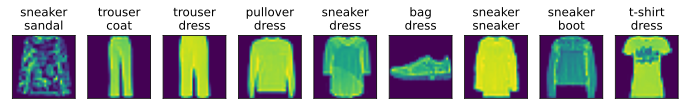

In [15]:
def get_fashion_mnist_labels(labels):
  text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','sneaker','bag','ankle','boot']
  return [text_labels[int(i)] for i in labels]
def show_fashion_mnist(images,labels):
  display.set_matplotlib_formats('svg')
  _,imgs = plt.subplots(1,len(images),figsize=(12,12))
  for img,figture,lbl in zip(imgs,images,labels):
    img.imshow(figture.view((28,28)).numpy())
    img.set_title(lbl)
    img.axes.get_xaxis().set_visible(False)
    img.axes.get_yaxis().set_visible(False)
  plt.show()
x,y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(x.to(device)).argmax(dim=1).cpu().numpy())
title = [true+'\n'+pred for true,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(x[0:9],title[0:9])